# Klasifikácia trás pomocou dát - Náhodné lesy
V tejto časti sa budeme chcieť použiť náhodné lesy ako klasifikátor.

## Importy a definície


In [1]:
#imports
import matplotlib.pyplot as plt
import seaborn as sns

from technicals import create_weekly_dataset, make_cycling_data, train_test_split_each_route, pd, np,classify
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error as MSE, classification_report as CR, ConfusionMatrixDisplay
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

c:\Users\kubko\Documents\School\R_3\PRIDAV\PRIDAV-JPD\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
cycling_data = make_cycling_data()
cycling_data.head()

,NAZOV,ZEMEPISNA_SIRKA,ZEMEPISNA_DLZKA,SMER_DO,SMER_Z,DATUM_A_CAS,POCET_DO,POCET_Z,ObjectId,datum_a_cas,hodina,den_v_tyzdni,mesiac,spolu
0,Most Apollo,48.134661,17.127928,Centrum,Petržalka,2025/04/22 23:00:00+00,0,0,1,2025-04-22 23:00:00+00:00,23,1,4,0
1,Most Apollo,48.134661,17.127928,Centrum,Petržalka,2025/04/22 22:00:00+00,0,0,2,2025-04-22 22:00:00+00:00,22,1,4,0
2,Most Apollo,48.134661,17.127928,Centrum,Petržalka,2025/04/22 21:00:00+00,0,0,3,2025-04-22 21:00:00+00:00,21,1,4,0
3,Most Apollo,48.134661,17.127928,Centrum,Petržalka,2025/04/22 20:00:00+00,0,0,4,2025-04-22 20:00:00+00:00,20,1,4,0
4,Most Apollo,48.134661,17.127928,Centrum,Petržalka,2025/04/22 19:00:00+00,0,0,5,2025-04-22 19:00:00+00:00,19,1,4,0


## Bez týždňových okien

In [3]:
features = ['POCET_Z', 'POCET_DO', 'hodina', 'den_v_tyzdni', 'mesiac']
only_cycled = cycling_data[cycling_data["spolu"] > 0]


In [4]:
X_train, X_test, y_train, y_test = train_test_split(only_cycled[features], only_cycled['NAZOV'], test_size=0.2, random_state=42)
y_train, y_test, class_weights_dict, class_names = classify(y_train,y_test)
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)
clf1 = RFC(n_estimators=100, random_state=42)
clf1.fit(X_train, y_train)


Klasifikujeme tieto lokality: ['Cyklomost' 'Devinska Nova Ves' 'Devínska cesta' 'Dolnozemská' 'Dunajská'
 'Einsteinova' 'Hradza' 'Most Apollo' 'Most SNP' 'Páričkova' 'River Park'
 'Starý Most' 'Trenčianska' 'Vajanského' 'Vajnorská' 'Viedenska'
 'Železná studnička'] 17


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

### Výsledok

Presnosť klasifikácie:
                   precision    recall  f1-score   support

        Cyklomost       0.30      0.37      0.33     11346
Devinska Nova Ves       0.41      0.47      0.44      5712
   Devínska cesta       0.09      0.05      0.07      2107
      Dolnozemská       0.38      0.33      0.36      3950
         Dunajská       0.19      0.17      0.18      5080
      Einsteinova       0.06      0.03      0.04       982
           Hradza       0.24      0.26      0.25     11507
      Most Apollo       0.11      0.07      0.09      2560
         Most SNP       0.10      0.07      0.08      3288
        Páričkova       0.23      0.22      0.23      4397
       River Park       0.25      0.20      0.22      4613
       Starý Most       0.34      0.34      0.34      8696
      Trenčianska       0.18      0.11      0.13      1283
       Vajanského       0.20      0.16      0.18      5517
        Vajnorská       0.42      0.46      0.44      6052
        Viedenska       0.32    

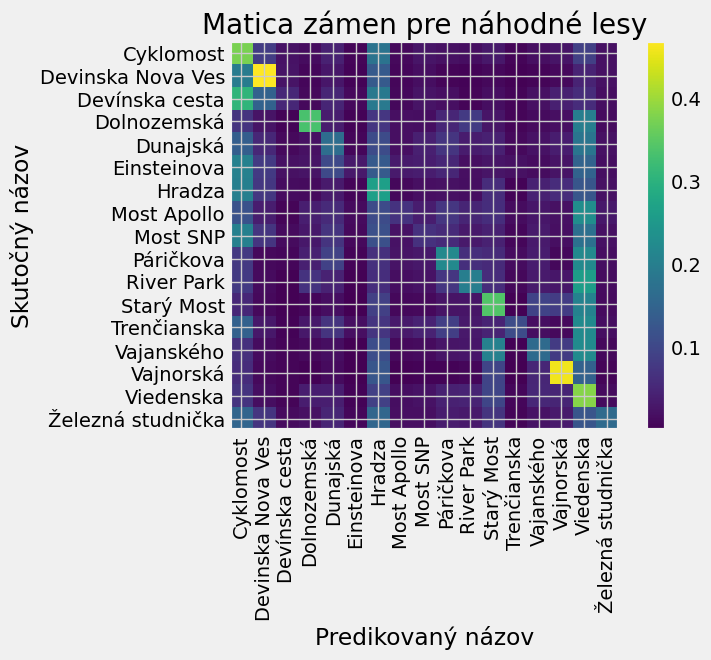

In [5]:
y_pred = clf1.predict(X_test)
print("Presnosť klasifikácie:")
print(CR(y_test, y_pred, target_names=class_names))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='viridis', display_labels=class_names,
    xticks_rotation='vertical', include_values=False, normalize='true')
plt.title("Matica zámen pre náhodné lesy")
plt.xlabel("Predikovaný názov")
plt.ylabel("Skutočný názov")
plt.show()

### Dôležitosti atribútov

In [6]:
importances = pd.Series(clf1.feature_importances_, index=features).sort_values(ascending=False)
print("\nNajdôležitejšie faktory pre určenie názvu:")
print(importances)


Najdôležitejšie faktory pre určenie názvu:
POCET_DO        0.250501
POCET_Z         0.220064
hodina          0.204099
den_v_tyzdni    0.166003
mesiac          0.159333
dtype: float64


## Týždňové okná

In [7]:
X, y = create_weekly_dataset(cycling_data)
print(f"Počet vzoriek (triedy x týždne): {X.shape[0]}")
print(f"Počet príznakov (hodín) na vzorku: {X.shape[1]}")
print(f"Počet tried (cyklosčítačov): {np.unique(y).shape[0]}")

Počet vzoriek (triedy x týždne): 3786
Počet príznakov (hodín) na vzorku: 336
Počet tried (cyklosčítačov): 17


### Model

In [8]:
X_train, X_test, y_train, y_test = train_test_split_each_route(X, y, test_size=0.3)

y_train, y_test, class_weights_dict, class_names = classify(y_train,y_test)
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)
clf2 = RFC(n_estimators=100, random_state=42, class_weight=class_weights_dict)
clf2.fit(X_train, y_train)


Klasifikujeme tieto lokality: ['Cyklomost' 'Devinska Nova Ves' 'Devínska cesta' 'Dolnozemská' 'Dunajská'
 'Einsteinova' 'Hradza' 'Most Apollo' 'Most SNP' 'Páričkova' 'River Park'
 'Starý Most' 'Trenčianska' 'Vajanského' 'Vajnorská' 'Viedenska'
 'Železná studnička'] 17


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

### Výsledok

Presnosť klasifikácie:
                   precision    recall  f1-score   support

        Cyklomost       0.79      0.70      0.75       179
Devinska Nova Ves       0.58      0.96      0.72        96
   Devínska cesta       0.83      0.11      0.20        45
      Dolnozemská       0.91      0.81      0.86        52
         Dunajská       0.72      0.30      0.42        44
      Einsteinova       0.57      0.57      0.57        14
           Hradza       0.56      0.67      0.61       173
      Most Apollo       0.15      0.05      0.07        44
         Most SNP       0.50      0.20      0.29        45
        Páričkova       0.73      0.91      0.81        45
       River Park       0.95      0.69      0.80        52
       Starý Most       0.92      0.92      0.92        52
      Trenčianska       0.82      0.64      0.72        14
       Vajanského       1.00      0.80      0.89        30
        Vajnorská       0.90      0.40      0.55        45
        Viedenska       0.51    

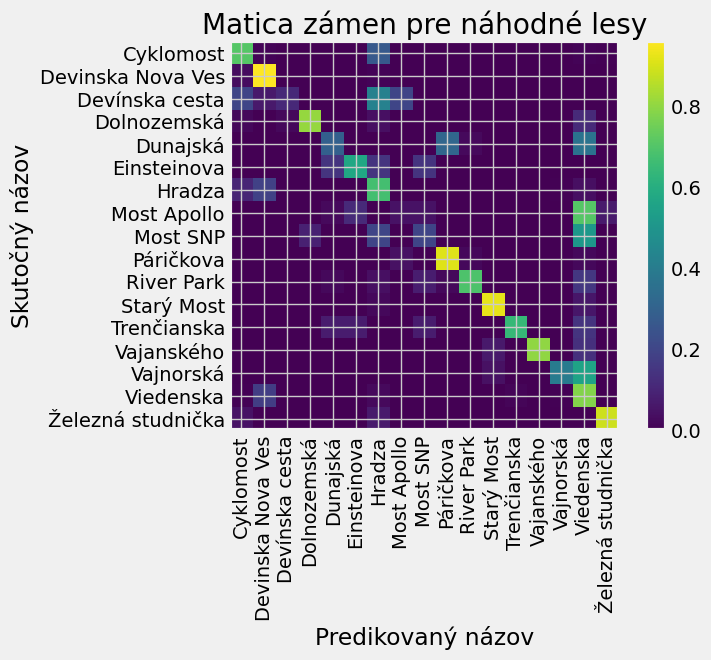

In [9]:
y_pred = clf2.predict(X_test)
print("Presnosť klasifikácie:")
print(CR(y_test, y_pred, target_names=class_names))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='viridis', display_labels=class_names,
    xticks_rotation='vertical', include_values=False, normalize='true')
plt.title("Matica zámen pre náhodné lesy")
plt.xlabel("Predikovaný názov")
plt.ylabel("Skutočný názov")
plt.show()

### Analýza dôležitosti

Najdôležitejšie faktory pre určenie názvu (hodiny v týždni):


C:\Users\kubko\AppData\Local\Temp\ipykernel_16752\3737658053.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(data=importances.groupby(["Časť_dňa","Deň_názov"])["Dôležitosť"].mean().reset_index(), x="Deň_názov", y="Dôležitosť", hue="Časť_dňa")


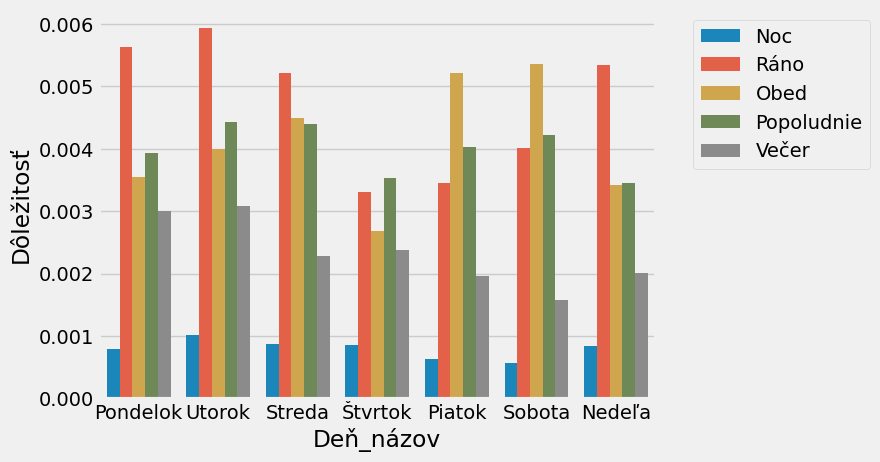

In [10]:
print("Najdôležitejšie faktory pre určenie názvu (hodiny v týždni):")
importances = pd.Series(clf2.feature_importances_, index=[i for i in range(X.shape[1])])
importances = importances.reset_index()
importances.columns = ['Hodina_z_do', 'Dôležitosť']
importances["Hodina"] = importances["Hodina_z_do"] % 168

importances["Smer"] = importances["Hodina_z_do"] // 168
importances["Smer"] = pd.Categorical(importances["Smer"].astype(str).replace({'0':'Z','1':'DO'}), categories=['Z','DO'], ordered=True)

importances["Deň"] = importances["Hodina"] // 24
importances["Deň_názov"] = importances["Deň"].astype(str).replace({'0':'Pondelok','1':'Utorok','2':'Streda','3':'Štvrtok','4':'Piatok','5':'Sobota','6':'Nedeľa'})
importances["Deň_názov"] = pd.Categorical(importances["Deň_názov"], categories=['Pondelok','Utorok','Streda','Štvrtok','Piatok','Sobota','Nedeľa'], ordered=True)

importances["Hodina_dňa"] = importances["Hodina"] % 24

importances["Časť_dňa"] = pd.cut(importances["Hodina_dňa"], bins=[-6,4,10,13,17,21,24], labels=['Noc','Ráno','Obed','Popoludnie', 'Večer', 'Noc_večer'])
importances["Časť_dňa"] = importances["Časť_dňa"].astype(str).replace('Noc_večer', 'Noc')
kategorie = ['Noc', 'Ráno', 'Obed', 'Popoludnie', 'Večer']
importances["Časť_dňa"] = pd.Categorical(importances["Časť_dňa"], categories=kategorie, ordered=True)

sns.barplot(data=importances.groupby(["Časť_dňa","Deň_názov"])["Dôležitosť"].mean().reset_index(), x="Deň_názov", y="Dôležitosť", hue="Časť_dňa")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

C:\Users\kubko\AppData\Local\Temp\ipykernel_16752\2380493378.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(data=importances.groupby(["Časť_dňa","Smer"])["Dôležitosť"].mean().reset_index(), x="Časť_dňa", y="Dôležitosť", hue="Smer")


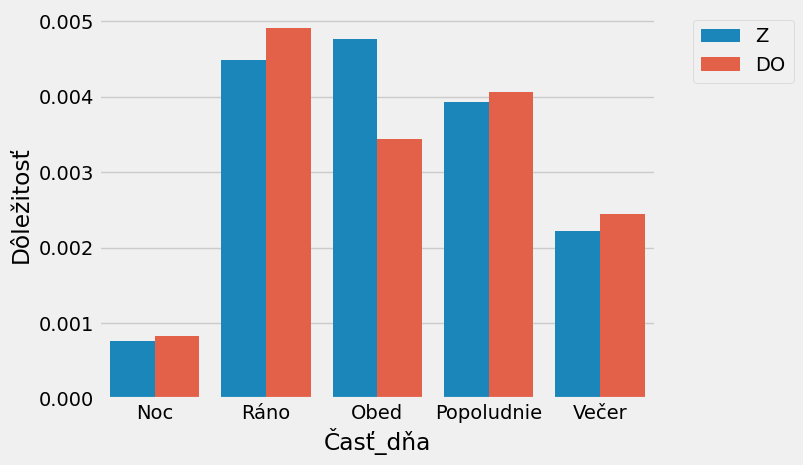

In [11]:
sns.barplot(data=importances.groupby(["Časť_dňa","Smer"])["Dôležitosť"].mean().reset_index(), x="Časť_dňa", y="Dôležitosť", hue="Smer")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')